# Introducción a Explainable AI (XAI)

## Contenido

1. [Introducción a XAI](#1-introducción-a-xai)
2. [Importancia de la Explicabilidad](#2-importancia-de-la-explicabilidad)
3. [Tipos de Interpretabilidad](#3-tipos-de-interpretabilidad)
4. [Técnicas de Interpretabilidad Intrínseca](#4-técnicas-de-interpretabilidad-intrínseca)
   - [Árboles de Decisión](#41-árboles-de-decisión)
   - [Regresión Lineal](#42-regresión-lineal)
5. [Técnicas de Interpretabilidad Post-hoc](#5-técnicas-de-interpretabilidad-post-hoc)
   - [LIME](#51-lime-local-interpretable-model-agnostic-explanations)
   - [SHAP](#52-shap-shapley-additive-explanations)
   - [Partial Dependence Plots](#53-partial-dependence-plots)
6. [Interpretabilidad en Redes Neuronales](#6-interpretabilidad-en-redes-neuronales)
   - [Visualización de Activaciones](#61-visualización-de-activaciones)
   - [GradCAM](#62-gradcam)
7. [Detección y Mitigación de Sesgos](#7-detección-y-mitigación-de-sesgos)

# 1. Introducción a XAI

Explainable AI (XAI) o Inteligencia Artificial Explicable es un conjunto de herramientas, técnicas y métodos que permiten a los humanos entender y confiar en los resultados y conclusiones generados por modelos de Machine Learning. A medida que los algoritmos se vuelven más complejos, la necesidad de explicar sus decisiones se hace más crítica.

En esta clase, aprenderemos técnicas para interpretar y explicar diferentes tipos de modelos de ML, desde los más simples hasta los más complejos.

Vamos a importar las bibliotecas que utilizaremos a lo largo de este notebook:

In [1]:
# Bibliotecas generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Configuración de visualización

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Para ignorar advertencias

In [3]:
import warnings
warnings.filterwarnings('ignore')

Scikit-learn para modelos y métricas

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Bibliotecas específicas para XAI

In [9]:
#%pip install lime
#%pip install shap
#%pip install pdpbox
#%pip install eli5
import shap
from sklearn.inspection import permutation_importance
from lime import lime_tabular
from pdpbox import pdp

In [10]:
print("¡Bibliotecas importadas correctamente!")

¡Bibliotecas importadas correctamente!


# 2. Importancia de la Explicabilidad

La explicabilidad en IA es fundamental por varias razones:
1. **Confianza**: Los usuarios necesitan confiar en los sistemas de IA para adoptarlos.
2. **Transparencia**: Entender cómo se toman las decisiones es esencial en aplicaciones críticas.
3. **Depuración**: La explicabilidad ayuda a identificar errores y mejora los modelos.
4. **Regulación**: Leyes como GDPR en Europa requieren explicaciones de decisiones automatizadas.
5. **Ética**: La explicabilidad permite detectar y mitigar sesgos algorítmicos.

El equilibrio entre rendimiento y explicabilidad es un desafío constante:

In [11]:
# Visualización del dilema entre explicabilidad y rendimiento
models = ['Regresión Lineal', 'Árboles de Decisión', 'Random Forest',
          'Gradient Boosting', 'Redes Neuronales', 'Deep Learning']
performance = [70, 75, 82, 87, 90, 95]  # Valores ilustrativos
explainability = [95, 90, 75, 60, 40, 20]  # Valores ilustrativos

Añadimos etiquetas a cada punto

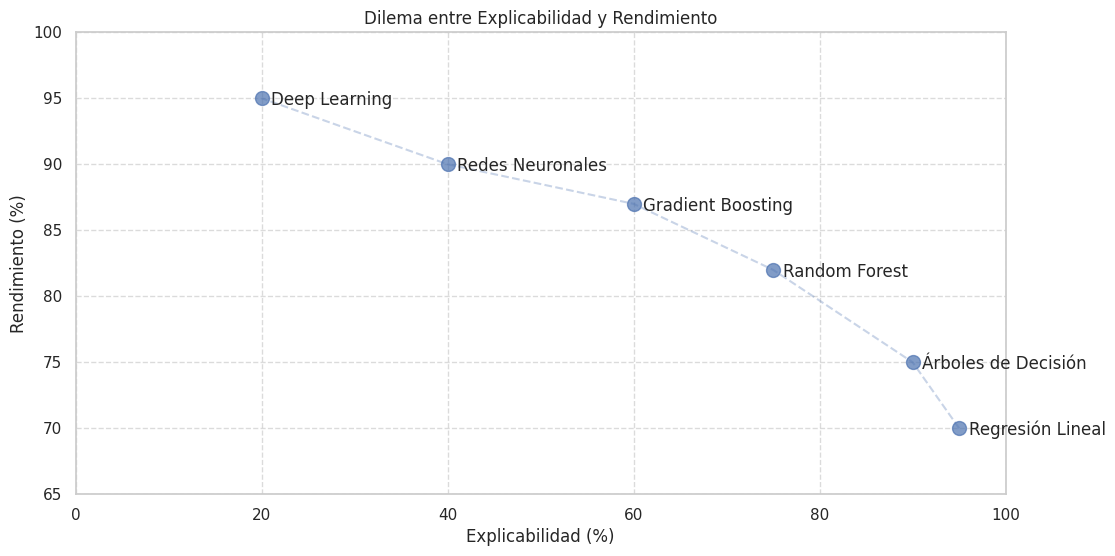

In [114]:
plt.figure(figsize=(12, 6))
plt.scatter(explainability, performance, s=100, alpha=0.7)
for i, model in enumerate(models):
    plt.annotate(model, (explainability[i], performance[i]),
                 xytext=(7, -5), textcoords='offset points')

plt.plot(explainability, performance, 'b--', alpha=0.3)
plt.xlabel('Explicabilidad (%)')
plt.ylabel('Rendimiento (%)')
plt.title('Dilema entre Explicabilidad y Rendimiento')
plt.xlim(0, 100)
plt.ylim(65, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Tipos de Interpretabilidad

Existen diferentes enfoques para la interpretabilidad de los modelos:

### Interpretabilidad Intrínseca vs. Post-hoc

- **Intrínseca**: El modelo es interpretable por su propia naturaleza (ej. regresión lineal, árboles de decisión).
- **Post-hoc**: Se aplican técnicas externas para explicar un modelo opaco ya entrenado (ej. LIME, SHAP).

### Interpretabilidad Global vs. Local

- **Global**: Explica el comportamiento del modelo en todo el conjunto de datos (ej. importancia de características).
- **Local**: Explica predicciones individuales (ej. por qué el modelo clasificó este cliente específico como riesgoso).

Para tener un contexto, vamos a cargar algunos datos para trabajar a lo largo de la clase:

In [15]:
# Cargar dataset para ejemplos
from sklearn.datasets import load_breast_cancer

Cargamos datos

In [16]:
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target)

Exploramos los datos

In [17]:
print(f"Forma del dataset: {X.shape}")
print(f"Distribución de clases: {y.value_counts().to_dict()}")
print(f"Nombres de características: {X.columns.tolist()[:5]}... (y {len(X.columns)-5} más)")

Forma del dataset: (569, 30)
Distribución de clases: {1: 357, 0: 212}
Nombres de características: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']... (y 25 más)


Dividimos los datos en conjuntos de entrenamiento y prueba

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Escalamos las características

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

Entrenamos algunos modelos que usaremos a lo largo de la clase

In [20]:
print("\nEntrenando modelos para explicar...")


Entrenando modelos para explicar...


Modelo intrínsecamente interpretable: árbol de decisión

In [21]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train_scaled, y_train)
tree_pred = tree_model.predict(X_test_scaled)
tree_accuracy = accuracy_score(y_test, tree_pred)
print(f"Exactitud del árbol de decisión: {tree_accuracy:.4f}")

Exactitud del árbol de decisión: 0.9649


Modelo más complejo: Random Forest

In [22]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Exactitud del Random Forest: {rf_accuracy:.4f}")

Exactitud del Random Forest: 0.9708


Modelo lineal: Regresión Logística

In [24]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Exactitud de la Regresión Logística: {lr_accuracy:.4f}")

Exactitud de la Regresión Logística: 0.9825


# 4. Técnicas de Interpretabilidad Intrínseca

Algunos modelos son interpretables por naturaleza. Vamos a explorar cómo interpretar árboles de decisión y modelos lineales.

## 4.1 Árboles de Decisión

Los árboles de decisión son intrínsecamente interpretables, ya que podemos visualizar directamente su estructura y las reglas de decisión.

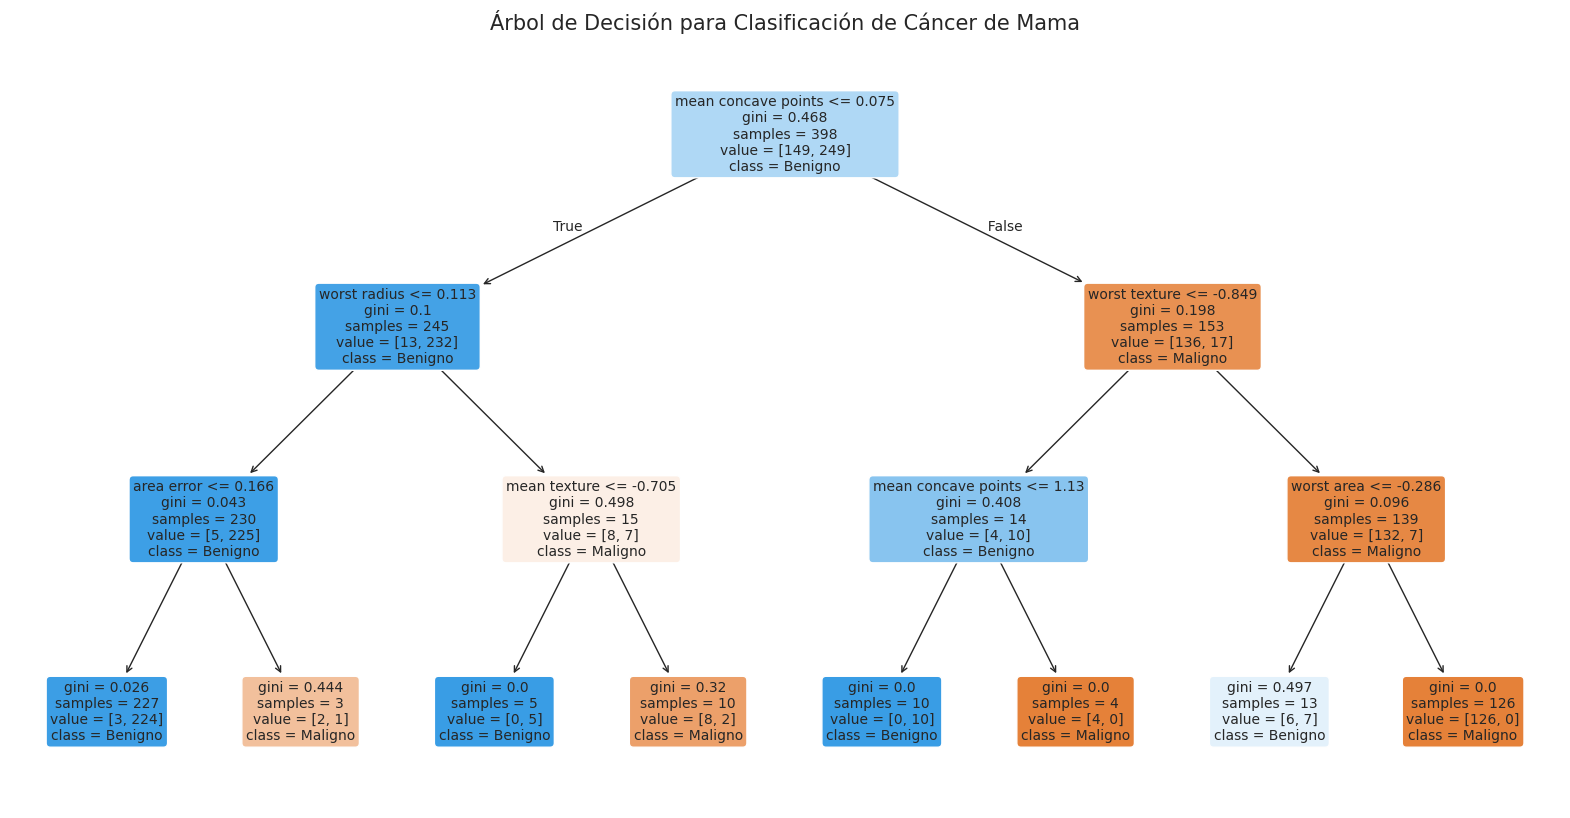

In [25]:

# Visualización del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=['Maligno', 'Benigno'],
          filled=True, rounded=True, fontsize=10)
plt.title('Árbol de Decisión para Clasificación de Cáncer de Mama', fontsize=15)
plt.show()

Analizamos las reglas más importantes

In [26]:
n_nodes = tree_model.tree_.node_count
children_left = tree_model.tree_.children_left
children_right = tree_model.tree_.children_right
feature = tree_model.tree_.feature
threshold = tree_model.tree_.threshold
impurity = tree_model.tree_.impurity

Identificamos las rutas de decisión principales

In [27]:
def extract_decision_path(node, feature_names, class_names, depth=0, path=None):
    if path is None:
        path = []

    # Si es un nodo hoja, imprime la clase y la ruta
    if children_left[node] == children_right[node]:
        class_prob = tree_model.tree_.value[node][0]
        class_idx = np.argmax(class_prob)
        total = class_prob.sum()
        class_percentage = 100 * class_prob[class_idx] / total

        print(f"Regla {len(path)+1}: SI", end=" ")
        for i, condition in enumerate(path):
            print(condition, end=" ")
            if i < len(path) - 1:
                print("Y", end=" ")
        print(f"ENTONCES clase = {class_names[class_idx]} ({class_percentage:.1f}% del nodo)")
        return

    # Añade condición a la ruta y continúa recursivamente
    feature_name = feature_names[feature[node]]

    # Rama izquierda (<=)
    path.append(f"{feature_name} <= {threshold[node]:.3f}")
    extract_decision_path(children_left[node], feature_names, class_names, depth+1, path)
    path.pop()

    # Rama derecha (>)
    path.append(f"{feature_name} > {threshold[node]:.3f}")
    extract_decision_path(children_right[node], feature_names, class_names, depth+1, path)
    path.pop()

In [28]:
print("Reglas de decisión extraídas del árbol:")
extract_decision_path(0, X.columns, ['Maligno', 'Benigno'])

Reglas de decisión extraídas del árbol:
Regla 4: SI mean concave points <= 0.075 Y worst radius <= 0.113 Y area error <= 0.166 ENTONCES clase = Benigno (98.7% del nodo)
Regla 4: SI mean concave points <= 0.075 Y worst radius <= 0.113 Y area error > 0.166 ENTONCES clase = Maligno (66.7% del nodo)
Regla 4: SI mean concave points <= 0.075 Y worst radius > 0.113 Y mean texture <= -0.705 ENTONCES clase = Benigno (100.0% del nodo)
Regla 4: SI mean concave points <= 0.075 Y worst radius > 0.113 Y mean texture > -0.705 ENTONCES clase = Maligno (80.0% del nodo)
Regla 4: SI mean concave points > 0.075 Y worst texture <= -0.849 Y mean concave points <= 1.130 ENTONCES clase = Benigno (100.0% del nodo)
Regla 4: SI mean concave points > 0.075 Y worst texture <= -0.849 Y mean concave points > 1.130 ENTONCES clase = Maligno (100.0% del nodo)
Regla 4: SI mean concave points > 0.075 Y worst texture > -0.849 Y worst area <= -0.286 ENTONCES clase = Benigno (53.8% del nodo)
Regla 4: SI mean concave points 

## 4.2 Regresión Lineal

Los modelos lineales son interpretables a través de sus coeficientes, que indican la importancia y dirección de influencia de cada característica.

In [29]:
# Interpretación de la regresión logística
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
})
coef_df = coef_df.sort_values('Coefficient', ascending=False)

Visualizamos los coeficientes

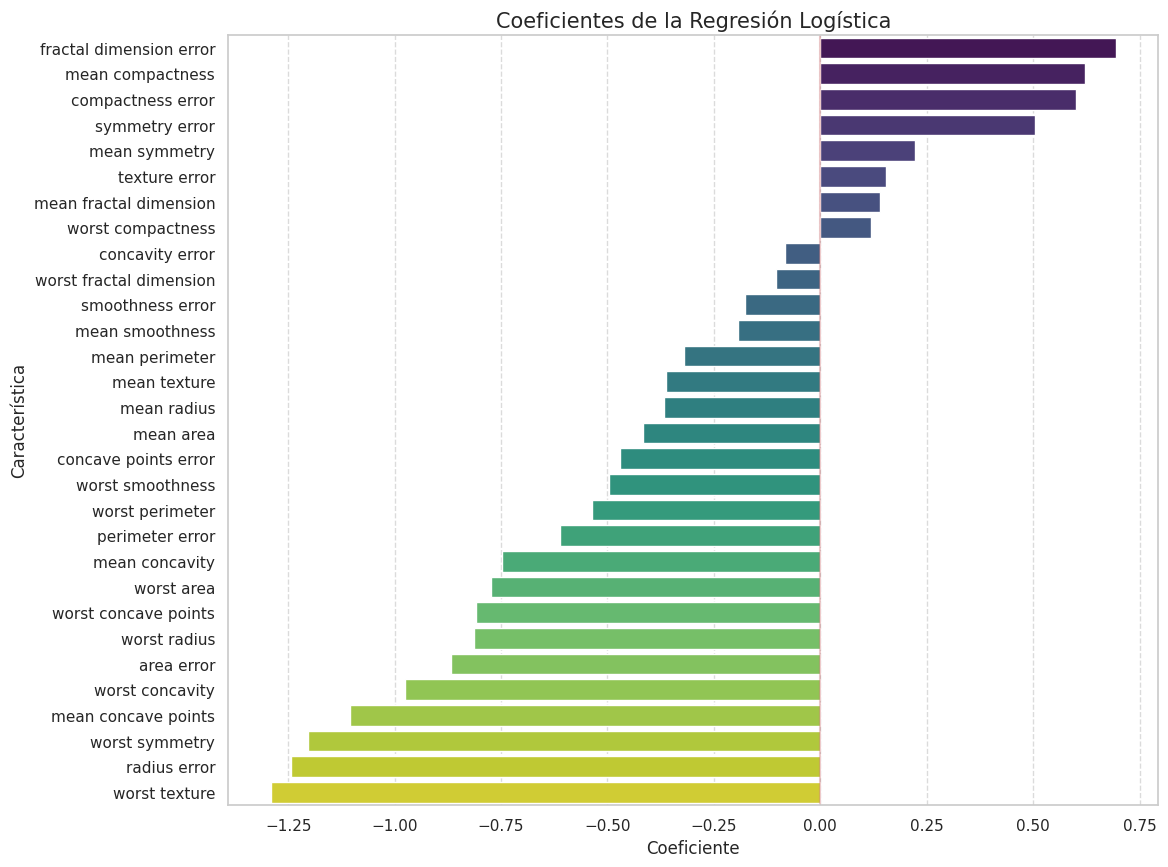

In [30]:
plt.figure(figsize=(12, 10))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
plt.title('Coeficientes de la Regresión Logística', fontsize=15)
plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Coeficiente')
plt.ylabel('Característica')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

Interpretando los odds ratio

In [31]:
odds_ratio = pd.DataFrame({
    'Feature': X.columns,
    'Odds Ratio': np.exp(lr_model.coef_[0])
})
odds_ratio = odds_ratio.sort_values('Odds Ratio', ascending=False)

In [32]:
print("Top 5 características que aumentan la probabilidad de diagnóstico benigno:")
print(odds_ratio.head(5))
print("\nTop 5 características que aumentan la probabilidad de diagnóstico maligno:")
print(odds_ratio.tail(5))

Top 5 características que aumentan la probabilidad de diagnóstico benigno:
                    Feature  Odds Ratio
19  fractal dimension error    2.003431
5          mean compactness    1.862693
15        compactness error    1.823491
18           symmetry error    1.657735
8             mean symmetry    1.248103

Top 5 características que aumentan la probabilidad de diagnóstico maligno:
                Feature  Odds Ratio
26      worst concavity    0.377240
7   mean concave points    0.331660
28       worst symmetry    0.300443
10         radius error    0.288176
21        worst texture    0.274959


# 5. Técnicas de Interpretabilidad Post-hoc

Para modelos más complejos como Random Forest, Gradient Boosting o Redes Neuronales, necesitamos técnicas post-hoc para entender sus predicciones.

## 5.1 LIME (Local Interpretable Model-agnostic Explanations)

LIME explica predicciones individuales generando un modelo local interpretable alrededor de la predicción.

In [33]:
# Aplicamos LIME para explicar una predicción del Random Forest
explainer = lime_tabular.LimeTabularExplainer(
    X_train_scaled,
    feature_names=X.columns,
    class_names=['Maligno', 'Benigno'],
    mode='classification'
)

Seleccionamos una instancia para explicar

In [34]:
instance_idx = 10
instance = X_test_scaled[instance_idx:instance_idx+1]
true_label = y_test.iloc[instance_idx]
pred_label = rf_model.predict(instance)[0]

Generamos la explicación

In [35]:
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=rf_model.predict_proba,
    num_features=10
)

Visualizamos la explicación

<Figure size 1000x600 with 0 Axes>

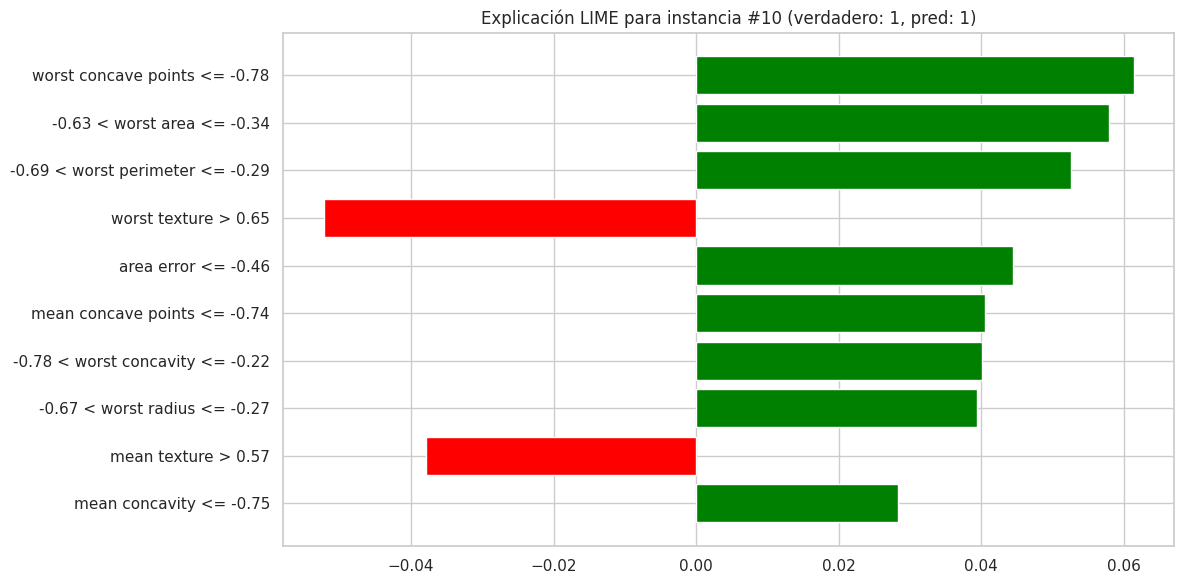

In [36]:
plt.figure(figsize=(10, 6))
explanation.as_pyplot_figure()
plt.title(f'Explicación LIME para instancia #{instance_idx} (verdadero: {true_label}, pred: {pred_label})')
plt.tight_layout()
plt.show()

Extraemos y mostramos los detalles de la explicación

In [37]:
feature_importance = explanation.as_list()
print("Explicación detallada de LIME:")
for feature, importance in feature_importance:
    print(f"- {feature}: {importance:.4f}")

Explicación detallada de LIME:
- worst concave points <= -0.78: 0.0614
- -0.63 < worst area <= -0.34: 0.0580
- -0.69 < worst perimeter <= -0.29: 0.0526
- worst texture > 0.65: -0.0523
- area error <= -0.46: 0.0445
- mean concave points <= -0.74: 0.0405
- -0.78 < worst concavity <= -0.22: 0.0402
- -0.67 < worst radius <= -0.27: 0.0394
- mean texture > 0.57: -0.0379
- mean concavity <= -0.75: 0.0283


## 5.2 SHAP (SHapley Additive exPlanations)

SHAP se basa en la teoría de juegos para asignar importancias a cada característica.

Calculamos los valores SHAP para el conjunto de prueba (o una muestra)

Visualización del resumen de valores SHAP

<Figure size 1000x800 with 0 Axes>

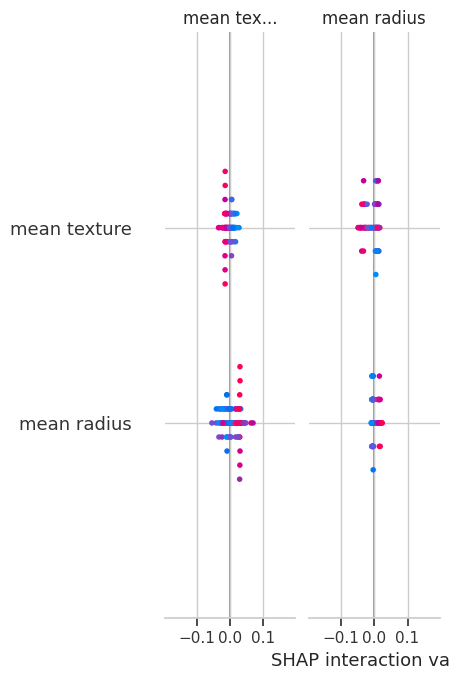

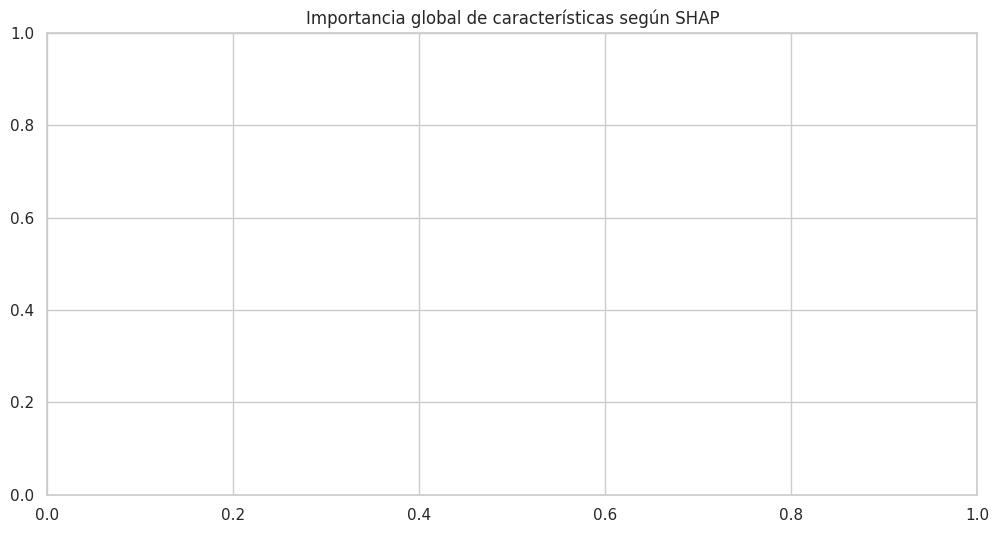

In [113]:
# Creamos un explicador SHAP para el modelo de Random Forest
# Usamos una muestra más pequeña del conjunto de entrenamiento para agilizar los cálculos
explainer = shap.Explainer(rf_model, X_train_scaled[:100])

shap_values = explainer(X_test_scaled[:100])

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled_df[:100], plot_type="bar")
plt.title("Importancia global de características según SHAP")
plt.show()

Visualización detallada que muestra el impacto y dirección

<Figure size 1000x800 with 0 Axes>

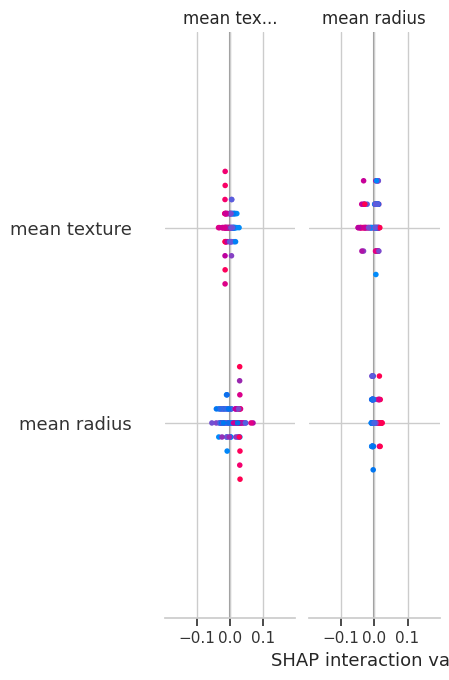

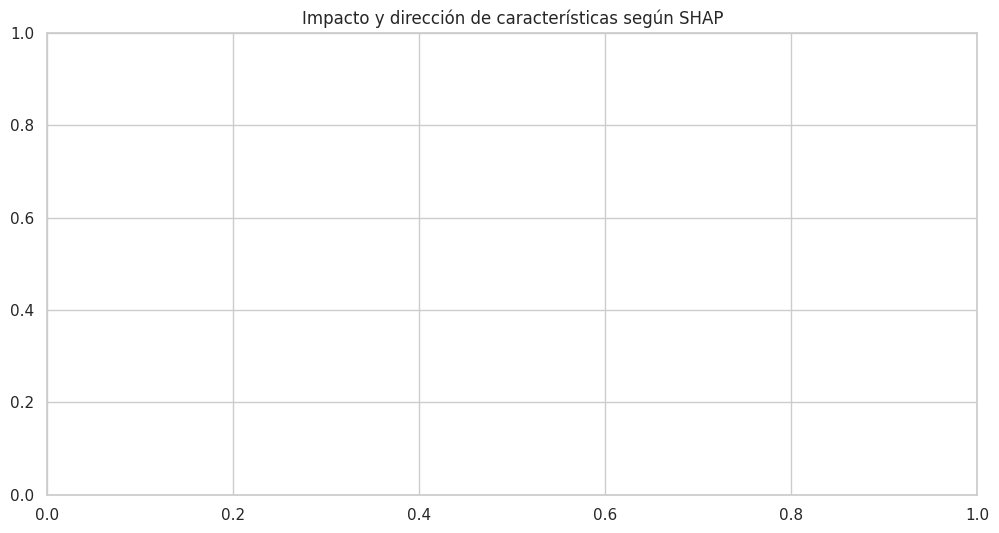

In [41]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled_df[:100])
plt.title("Impacto y dirección de características según SHAP")
plt.show()

# 6. Interpretabilidad en Redes Neuronales

Las redes neuronales son notoriamente difíciles de interpretar. Vamos a explorar algunas técnicas para hacerlas más transparentes.

## 6.1 Visualización de Activaciones

In [55]:
# Creamos una red neuronal simple con TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

Configuramos el modelo

In [56]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

Compilamos el modelo

In [57]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Mostramos la arquitectura

In [58]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo (con early stopping)

In [59]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Evaluamos el modelo

In [60]:
nn_loss, nn_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Exactitud de la red neuronal: {nn_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9713 - loss: 0.0851 
Exactitud de la red neuronal: 0.9708


Visualizamos el historial de entrenamiento

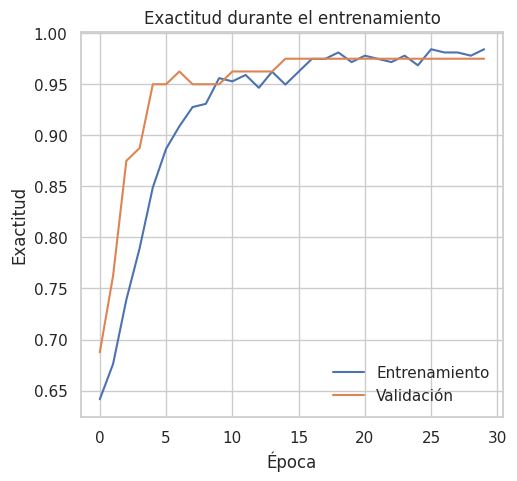

In [61]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Exactitud durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.legend()

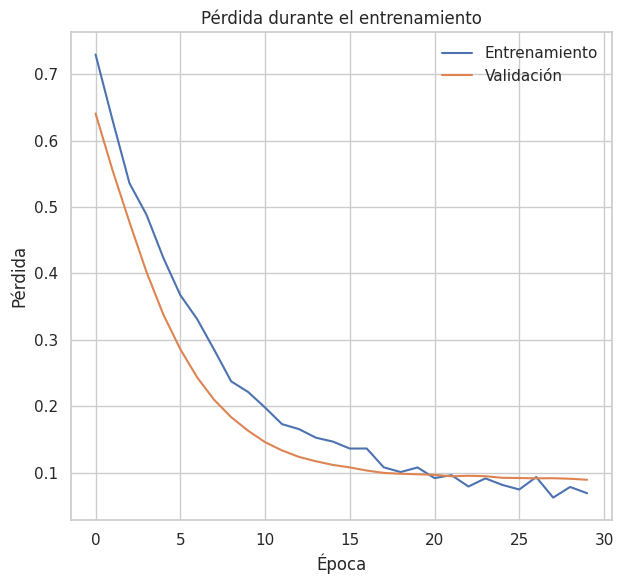

In [62]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.tight_layout()
plt.show()

Creamos un modelo modificado para obtener las activaciones intermedias

In [65]:
# Tu modelo ya está entrenado, solo necesitas definir el modelo de activaciones correctamente
# Para Sequential, necesitas usar model.layers[0].input en lugar de model.input
layer_outputs = [layer.output for layer in model.layers if 'dropout' not in layer.name.lower()]
activation_model = tf.keras.models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

Obtenemos activaciones para una instancia

In [66]:
instance_to_explain = X_test_scaled[0:1]
activations = activation_model.predict(instance_to_explain)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Visualizamos las activaciones

In [67]:
plt.figure(figsize=(15, 10))
layer_names = [f"Capa {i+1}" for i, layer in enumerate(model.layers) if 'dropout' not in layer.name.lower()]

<Figure size 1500x1000 with 0 Axes>

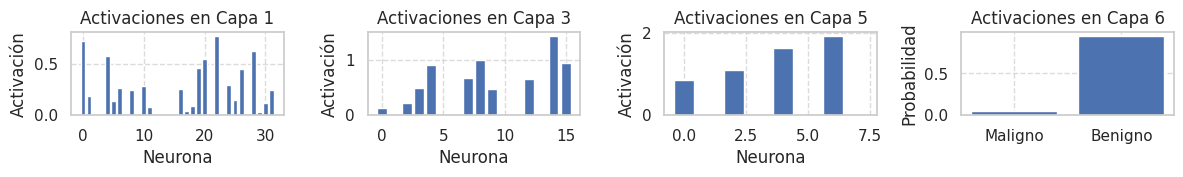

In [74]:
for i, (activation, layer_name) in enumerate(zip(activations, layer_names)):
    plt.subplot(4, 4, i+1)
    plt.title(f'Activaciones en {layer_name}')

    if i < len(activations) - 1:  # No es la capa de salida
        plt.bar(range(activation.shape[1]), activation[0])
        plt.xlabel('Neurona')
        plt.ylabel('Activación')
    else:  # Capa de salida
        plt.bar(['Maligno', 'Benigno'], [1-activation[0][0], activation[0][0]])
        plt.ylabel('Probabilidad')

    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 6.2 GradCAM

GradCAM es una técnica de visualización que utilizaremos para entender qué partes de una imagen son importantes para una red neuronal convolucional. Aunque es más relevante para imágenes, podemos ver un ejemplo conceptual:

Creamos un modelo simplificado para calcular gradientes

In [77]:
grad_model = tf.keras.models.Model(
    inputs=model.layers[0].input,
    outputs=[model.get_layer('dense_3').output, model.layers[-1].output]
)

Función para calcular los mapas de activación ponderados por gradientes

In [85]:
def get_gradcam(input_instance):
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(input_instance)
        target_class = 0 if predictions[0][0] < 0.5 else 1
        target = predictions[:, 0]

    grads = tape.gradient(target, last_conv_layer_output)
    weights = tf.reduce_mean(grads, axis=0)
    cam = tf.reduce_sum(tf.multiply(weights, last_conv_layer_output), axis=1)

    return cam.numpy()
instance_idx = 0
instance = X_test_scaled[instance_idx:instance_idx+1]
cam = get_gradcam(instance)
cam = cam - cam.min()
if cam.max() > 0:
    cam = cam / cam.max()

plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

Histograma de valores originales

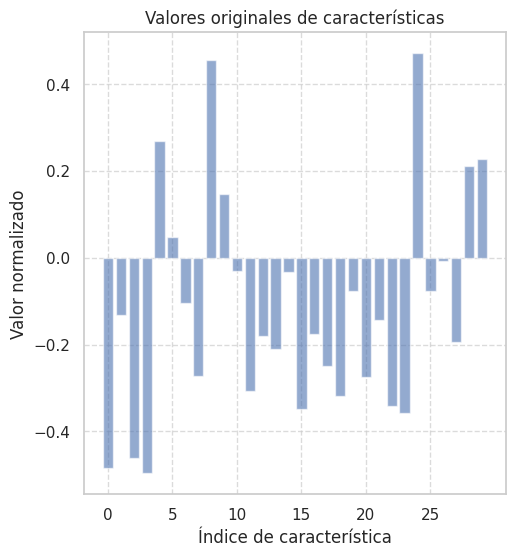

In [86]:
plt.subplot(1, 2, 1)
plt.bar(range(len(X.columns)), instance[0], alpha=0.6)
plt.title('Valores originales de características')
plt.xlabel('Índice de característica')
plt.ylabel('Valor normalizado')
plt.xticks(range(0, len(X.columns), 5))
plt.grid(True, linestyle='--', alpha=0.7)

# 7. Detección y Mitigación de Sesgos

XAI nos permite detectar sesgos en nuestros modelos, lo que es crucial para garantizar la equidad y la confianza.

In [90]:
# Crear un dataset sintético para demostrar sesgos
np.random.seed(42)

Simulamos dos grupos demográficos

In [91]:
n_grupo1 = 800
n_grupo2 = 200

Características con diferentes distribuciones

In [92]:
X_grupo1 = np.random.normal(0, 1, (n_grupo1, 2))
X_grupo2 = np.random.normal(1, 1, (n_grupo2, 2))

Etiquetas con diferente distribución

In [93]:
y_grupo1 = np.random.binomial(1, 0.7, n_grupo1)  # 70% positivos
y_grupo2 = np.random.binomial(1, 0.3, n_grupo2)  # 30% positivos

Combinamos los datos

In [94]:
X_sesgado = np.vstack([X_grupo1, X_grupo2])
y_sesgado = np.hstack([y_grupo1, y_grupo2])
grupo = np.hstack([np.zeros(n_grupo1), np.ones(n_grupo2)])

Creamos un DataFrame

In [95]:
df_sesgado = pd.DataFrame({
    'caracteristica1': X_sesgado[:, 0],
    'caracteristica2': X_sesgado[:, 1],
    'etiqueta': y_sesgado,
    'grupo': grupo
})

Dividimos en entrenamiento y prueba

In [96]:
X_train_sesgado, X_test_sesgado, y_train_sesgado, y_test_sesgado, grupo_train, grupo_test = train_test_split(
    X_sesgado, y_sesgado, grupo, test_size=0.3, random_state=42)

Entrenamos un modelo potencialmente sesgado

In [97]:
model_sesgado = RandomForestClassifier(random_state=42)
model_sesgado.fit(X_train_sesgado, y_train_sesgado)

RandomForestClassifier(random_state=42)

Evaluamos el modelo por grupo

In [98]:
y_pred_sesgado = model_sesgado.predict(X_test_sesgado)

Función para evaluar métricas por grupo

In [99]:
def evaluate_bias(y_true, y_pred, group):
    groups = np.unique(group)
    results = {}

    for g in groups:
        mask = (group == g)

        tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask], labels=[0, 1]).ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        results[g] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity
        }

    return results

In [100]:
bias_results = evaluate_bias(y_test_sesgado, y_pred_sesgado, grupo_test)

Visualización de métricas por grupo

In [101]:
metrics = ['accuracy', 'precision', 'recall', 'specificity']
grupo0_metrics = [bias_results[0][metric] for metric in metrics]
grupo1_metrics = [bias_results[1][metric] for metric in metrics]

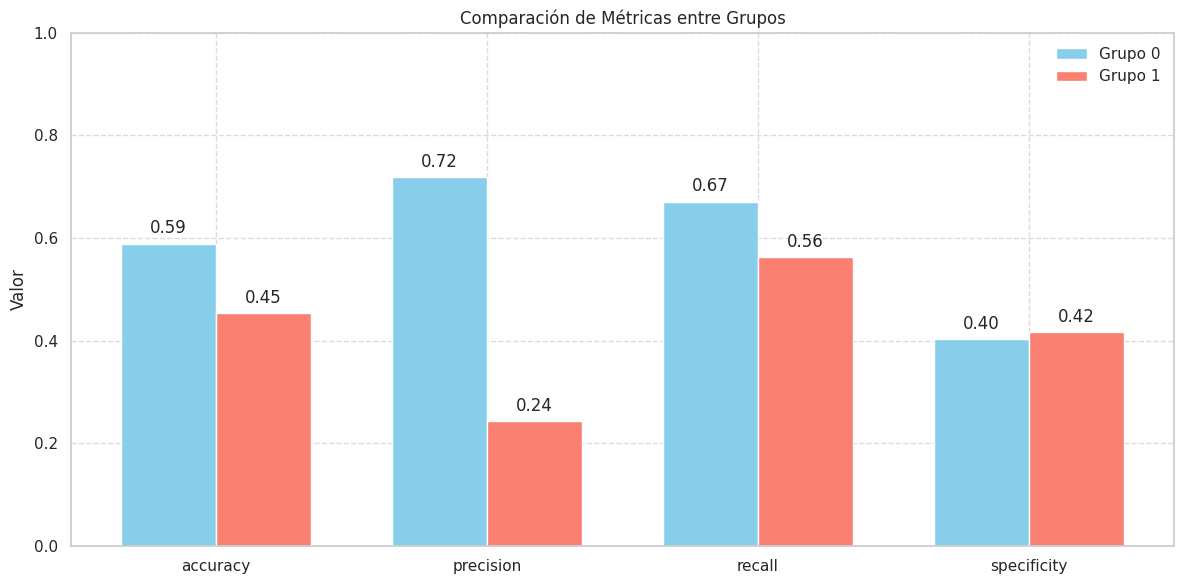

In [106]:
plt.figure(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, grupo0_metrics, width, label='Grupo 0', color='skyblue')
plt.bar(x + width/2, grupo1_metrics, width, label='Grupo 1', color='salmon')
plt.title('Comparación de Métricas entre Grupos')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

for i, v in enumerate(grupo0_metrics):
    plt.text(i - width/2, v + 0.02, f'{v:.2f}', ha='center')

for i, v in enumerate(grupo1_metrics):
    plt.text(i + width/2, v + 0.02, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

Análisis SHAP para detectar posibles sesgos en las características

Dividimos los valores SHAP por grupo

Text(0.5, 1.0, 'Importancia SHAP para Grupo 0')

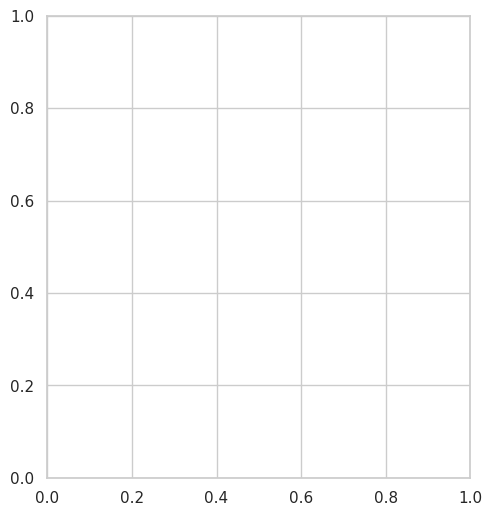

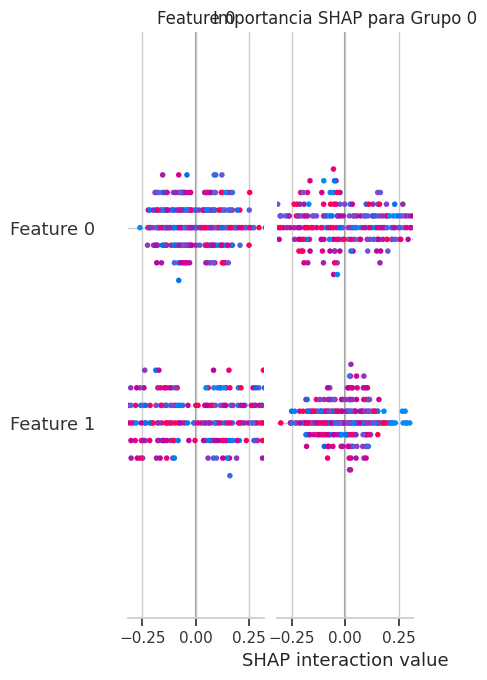

In [112]:
explainer_bias = shap.Explainer(model_sesgado)
shap_values_bias = explainer_bias(X_test_sesgado)
shap_grupo0 = shap_values_bias[grupo_test == 0]
shap_grupo1 = shap_values_bias[grupo_test == 1]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
shap.summary_plot(shap_grupo0, X_test_sesgado[grupo_test == 0],
                  plot_type="bar", show=False, plot_size=(5, 5))
plt.title("Importancia SHAP para Grupo 0")